# Ансамбли решающих функций (классификаторов)

На сегодняшний день существуют два подхода:
    
* Баггинг (построение независимых классификаторов):
        - Bagging
        - Random Forests
        - ...
* Бустинг (новые классификаторы знают об ошибках других и учатся на их ошибках):
        - AdaBoost
        - Gradient Boosting
        - ...


Dataset: [armenian pubs](https://www.kaggle.com/erikhambardzumyan/pubs)

Подробнее о данных можно узнать в [первой работе](https://github.com/andrgolubev/python-sandbox/blob/master/data_analysis_1.ipynb)

## Плюсы и минусы ансамблей деревьев решений

** Плюсы **:

* Все достоинства деревьев решений сохраняются (кроме возможности интерпретации решающего правила - но остается возможность определения значимости признаков)
* Хорошее (часто рекордное) качество предсказания
* Random Forest (почти) не переобучается (GBT, AdaBoost - чуть похуже)

** Минусы **:

* GBT, AdaBoost - много параметров, которые надо подбирать
* Медленно обучаются (особенно GBT, который требует обычно много деревьев)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import data_retrieve as dr
X, data = dr.parse_and_prepare("armenian_pubs.csv", sep=",", engine="python")
Y = None
Y_numeric = data['wts']
Y_mean = np.mean(Y_numeric)
Y = pd.Series(['C1' if val <= Y_mean else 'C2' for val in Y_numeric])
intY = pd.Series([0 if val is 'C1' else 1 for val in Y])
feature_names = X.columns

from sklearn.model_selection import train_test_split
# constant random_state to have repeatability
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=7)
N_train, _ = X_train.shape
N_test, _ = X_test.shape
intY = pd.Series([0 if val is 'C1' else 1 for val in Y_train])
intY_test = pd.Series([0 if val is 'C1' else 1 for val in Y_test])
print(N_train, N_test)

122 53


/home/andrgolubev/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Random Forest

Ансамбль параллельно обучаемых «независимых» деревьев решений.

Независимое построение определенного количества $M = {}$`n_estimators` (по умолчанию, 10) деревьев:

Генерация случайной bootstrap-подвыборки (по умолчанию, ее мощность равна $\sqrt{N}$) из обучающей выборки и построение дерева решений по данной подвыборке (в каждом
новом узле дерева переменная для разбиения выбирается не из всех признаков, а из
случайно выбранного их подмножества небольшой мощности).

In [3]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=700)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
err_train = np.mean(Y_train != rf_model.predict(X_train))
err_test = np.mean(Y_test != rf_model.predict(X_test))
print(err_train, err_test)

0.0 0.528301886792


In [5]:
n_estimators = []
for i in range(1, 700, 10):
    n_estimators.append(i)
    pass

Оптимальное число эстиматоров:

In [6]:
from sklearn.model_selection import GridSearchCV
rf_default = RandomForestClassifier()
# using cross-validation
rf_grid_cv = GridSearchCV(rf_default, param_grid = {'n_estimators': n_estimators}, cv=None, n_jobs=4)
rf_grid_cv.fit(X_train, Y_train)
best_cv_err = 1 - rf_grid_cv.best_score_
best_n_estimators = rf_grid_cv.best_estimator_.n_estimators
print(best_cv_err, best_n_estimators)

0.426229508197 161


## AdaBoost

Будем использовать веса $w_1,w_2, \dots ,w_N$.

На первой итерации $w_i = 1/N$ ($i = 1, 2, \dots ,N$) и алгоритм построения $f_1$ работает в
обычном режиме.
На $m$-й итерации увеличиваются веса тех прецедентов, на которых на $(m − 1)$-й
итерации была допущена ошибка, и уменьшаются веса тех прецедентов, которые на
предыдущей итерации были классифицированы правильно.

На $m$-й итерации ищем классификатор $f_m$, минимизирующий ошибку
$$
{\rm err}_m = \sum_{f_m(x^{(i)}) \ne y^{(i)}} w_i
$$


In [7]:
from sklearn.ensemble import AdaBoostClassifier
adab_model = AdaBoostClassifier(n_estimators=700)
adab_model.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=700, random_state=None)

In [8]:
err_train = np.mean(Y_train != adab_model.predict(X_train))
err_test = np.mean(Y_test != adab_model.predict(X_test))
print(err_train, err_test)

0.139344262295 0.509433962264


Оптимальное число эстиматоров:

In [9]:
from sklearn.model_selection import GridSearchCV
adab_default = AdaBoostClassifier()
# using cross-validation
adab_grid_cv = GridSearchCV(adab_default, param_grid = {'n_estimators': n_estimators}, cv=None, n_jobs=4)
adab_grid_cv.fit(X_train, Y_train)
best_cv_err = 1 - adab_grid_cv.best_score_
best_n_estimators = adab_grid_cv.best_estimator_.n_estimators
print(best_cv_err, best_n_estimators)

0.434426229508 1


## Gradient Boosting

На каждой итерации строится новый классификатор, аппроксимирующий значение градиента функции потерь

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
gdb_model = GradientBoostingClassifier(n_estimators=700)
gdb_model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=700,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [11]:
err_train = np.mean(Y_train != gdb_model.predict(X_train))
err_test = np.mean(Y_test != gdb_model.predict(X_test))
print(err_train, err_test)

0.0 0.547169811321


Оптимальное число эстиматоров:

In [12]:
from sklearn.model_selection import GridSearchCV
gdb_default = GradientBoostingClassifier()
# using cross-validation
gdb_grid_cv = GridSearchCV(gdb_default, param_grid = {'n_estimators': n_estimators}, cv=None, n_jobs=4)
gdb_grid_cv.fit(X_train, Y_train)
best_cv_err = 1 - gdb_grid_cv.best_score_
best_n_estimators = gdb_grid_cv.best_estimator_.n_estimators
print(best_cv_err, best_n_estimators)

0.409836065574 1


### Общие параметры для каждого дерева

In [13]:
from ipywidgets import interact

defines = {
    'random_forest': {
        'ctor': RandomForestClassifier
    },
    'ada_boost': {
        'ctor': AdaBoostClassifier
    },
    'gradient_boosting': {
        'ctor': GradientBoostingClassifier
    }
}

names = X.columns
_, n_features = X.shape
def print_svc_data(model='random_forest', graph='roc', n_estimators=700):
    model_defines = defines[model]
    tree_model = model_defines['ctor'](n_estimators=n_estimators)
    tree_model.fit(X_train, Y_train)
    Y_train_predict = tree_model.predict(X_train)
    Y_test_predict = tree_model.predict(X_test)
    err_train = np.mean(Y_train != Y_train_predict)
    err_test = np.mean(Y_test != Y_test_predict)
    print(f"Errors: train - {err_train} | test - {err_test}")
    from sklearn.metrics import confusion_matrix
    cm_train = confusion_matrix(Y_train_predict, Y_train)
    print("Train data Confusion Matrix:\n", cm_train)
    cm_test = confusion_matrix(Y_test_predict, Y_test)
    print("Test data Confusion Matrix:\n", cm_test)
    
    tnr_tr = 1 - float(cm_train[1, 0])/(cm_train[0, 0] + cm_train[1, 0])
    tpr_tr = 1 - float(cm_train[0, 1])/(cm_train[0, 1] + cm_train[1, 1])
    print(f"Train data: Specificity={tnr_tr} | Sensitivity={tpr_tr}")
    tnr_tst = 1 - float(cm_test[1, 0])/(cm_test[0, 0] + cm_test[1, 0])
    tpr_tst = 1 - float(cm_test[0, 1])/(cm_test[0, 1] + cm_test[1, 1])
    print(f"Test data: Specificity={tnr_tst} | Sensitivity={tpr_tst}")
    probability = tree_model.predict_proba(X_test)[:, 1]
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(intY_test, probability)
    
    importances = tree_model.feature_importances_
    indices = np.argsort(importances)[:-11:-1]
    print("Feature ranking:")
    for f in range(10):
        print("%2d. feature '%5s' (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
        
    plt.hist(probability[Y_test == 'C1'], color = 'b', alpha = 0.4, normed = False)
    plt.hist(probability[Y_test == 'C2'], color = 'r', alpha = 0.4, normed = False)
    
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(intY_test, probability)
    plt.title('Receiver Operating Characteristic')
    plt.plot(np.concatenate(([0], fpr)), np.concatenate(([0], tpr)))
    #plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    from sklearn.metrics import auc
    print("Area Under Curve: ", auc(fpr, tpr))
    pass

# interact(print_svc_data, model=defines.keys(), graph=['hist', 'roc'], n_estimators=(1, 2500, 1))
pass

RandomForest

Errors: train - 0.0 | test - 0.5660377358490566
Train data Confusion Matrix:
 [[72  0]
 [ 0 50]]
Test data Confusion Matrix:
 [[16 23]
 [ 7  7]]
Train data: Specificity=1.0 | Sensitivity=1.0
Test data: Specificity=0.6956521739130435 | Sensitivity=0.23333333333333328
Feature ranking:
 1. feature 'income' (0.172544)
 2. feature '  age' (0.132673)
 3. feature 'gender' (0.053683)
 4. feature 'occupation_Student' (0.051004)
 5. feature 'sec_imp_Music' (0.042266)
 6. feature 'freq_rarely' (0.040926)
 7. feature 'sec_imp_Pricing' (0.038409)
 8. feature 'freq_Several_times_in_a_month' (0.034144)
 9. feature 'sec_imp_Menu' (0.033086)
10. feature 'lifestyle_Busy' (0.032829)
Area Under Curve:  0.484057971014


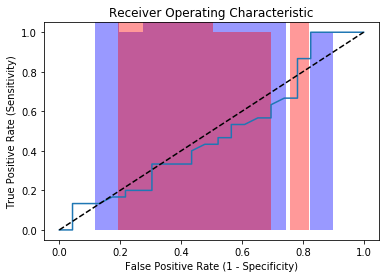

In [14]:
print_svc_data(model='random_forest', n_estimators=rf_grid_cv.best_estimator_.n_estimators)

AdaBoost

Errors: train - 0.36065573770491804 | test - 0.5471698113207547
Train data Confusion Matrix:
 [[71 43]
 [ 1  7]]
Test data Confusion Matrix:
 [[22 28]
 [ 1  2]]
Train data: Specificity=0.9861111111111112 | Sensitivity=0.14
Test data: Specificity=0.9565217391304348 | Sensitivity=0.06666666666666665
Feature ranking:
 1. feature '  age' (1.000000)
 2. feature 'sec_imp_Pricing' (0.000000)
 3. feature 'sec_imp_Menu' (0.000000)
 4. feature 'sec_imp_Environment' (0.000000)
 5. feature 'prim_imp_Pricing' (0.000000)
 6. feature 'prim_imp_Music' (0.000000)
 7. feature 'prim_imp_Menu' (0.000000)
 8. feature 'prim_imp_Environment' (0.000000)
 9. feature 'freq_rarely' (0.000000)
10. feature 'freq_Several_times_in_a_month' (0.000000)
Area Under Curve:  0.511594202899


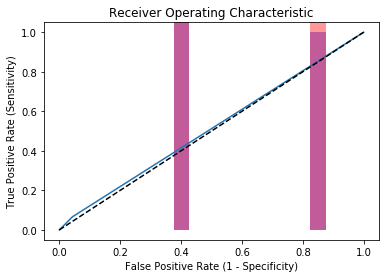

In [15]:
print_svc_data(model='ada_boost', n_estimators=adab_grid_cv.best_estimator_.n_estimators)

Gradient Boosting

Errors: train - 0.4098360655737705 | test - 0.5660377358490566
Train data Confusion Matrix:
 [[72 50]
 [ 0  0]]
Test data Confusion Matrix:
 [[23 30]
 [ 0  0]]
Train data: Specificity=1.0 | Sensitivity=0.0
Test data: Specificity=1.0 | Sensitivity=0.0
Feature ranking:
 1. feature '  age' (0.320982)
 2. feature 'freq_rarely' (0.227989)
 3. feature 'gender' (0.188439)
 4. feature 'sec_imp_Music' (0.151611)
 5. feature 'sec_imp_Pricing' (0.110979)
 6. feature 'income' (0.000000)
 7. feature 'freq_Several_times_in_a_month' (0.000000)
 8. feature 'sec_imp_Environment' (0.000000)
 9. feature 'prim_imp_Pricing' (0.000000)
10. feature 'prim_imp_Music' (0.000000)
Area Under Curve:  0.495652173913


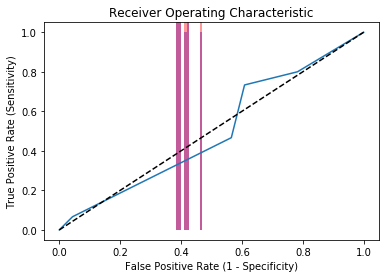

In [16]:
print_svc_data(model='gradient_boosting', n_estimators=gdb_grid_cv.best_estimator_.n_estimators)

# PCA

#### Сначала рассмотрим все компоненты исходной выборки и variance ratio, объясняемый каждой компонентой

In [17]:
from sklearn.decomposition import PCA
test_pca = PCA(n_components=41)
test_pca.fit(X)
print("Variance ratio:", list(map(lambda x: x * 100, test_pca.explained_variance_ratio_)))

Variance ratio: [13.750251926301463, 12.519204425529917, 10.903914690661825, 9.6843632284116747, 7.7391364963116507, 6.586544699922749, 6.2976602381936599, 5.4940469209237301, 4.5040899393102585, 4.0736519915250717, 3.2745385492491756, 2.3274341798427765, 1.9912927426164639, 1.8244584485123641, 1.7380701446250237, 1.4750579733295259, 0.9813248784693539, 0.90863557150003249, 0.82816710352869272, 0.5222752158386379, 0.42652135971759347, 0.39480831518946397, 0.30679214756040435, 0.21615558011842356, 0.20288764502201917, 0.19078998856428925, 0.15074993263867775, 0.13822941603165434, 0.13446490383409765, 0.12629344825484323, 0.11931481135714053, 0.086718661782530598, 0.059325957094657857, 0.016294966910864295, 0.006533501319281927, 2.7117590453997833e-30, 3.9848116094346523e-31, 2.223441382602472e-31, 1.2878440603021875e-31, 9.2418808796832532e-32, 5.1485548338127467e-32]


#### Возьмем только те компоненты, которые имеют порядок 10 и объясняют ~60% общей дисперсии

Получим 7 главных компонент

In [18]:
import math
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(X)
print("Variance ratio:", list(map(lambda x: str(int(x * 100 + 0.5)) + "%", pca.explained_variance_ratio_)))
print("Variance:", pca.explained_variance_)
# print("Principal axes:", pca.components_)
print("Singular values:", pca.singular_values_)

Variance ratio: ['14%', '13%', '11%', '10%', '8%', '7%', '6%']
Variance: [ 0.5338941   0.48609505  0.42337666  0.37602397  0.30049481  0.25574203
  0.24452524]
Singular values: [ 9.63833871  9.19676781  8.58297957  8.08876823  7.23091256  6.67076557
  6.52283616]


"Сожмем" исходные данные, оставив только главныe компоненты

In [19]:
X_with_pca = pd.DataFrame(pca.transform(X))

In [20]:
X.shape

(175, 41)

In [21]:
print(X_with_pca.shape)
X_with_pca.head()

(175, 7)


,0,1,2,3,4,5,6
0,0.134563,-1.104269,-0.612171,0.159850,0.260709,0.429692,0.034214
1,0.840335,0.722744,0.148524,-0.673097,0.032362,0.888287,0.306567
2,-0.916632,0.118781,-0.028603,0.218110,-0.598056,-0.236084,0.538700
3,-0.362633,-1.052839,-0.554140,-0.584881,-0.074192,-0.337969,0.308242
4,0.471825,0.463484,1.288841,-0.055789,0.293284,-0.168592,0.271670


Разделим сжатые данные таким же образом, как исходные (такие же размеры обучающей и тестовой выборок, то же случайное состояние (seed))

In [22]:
X_train_pca, X_test_pca, _, _ = train_test_split(X_with_pca, Y, train_size=0.7, random_state=7)
N_train_pca, _ = X_train_pca.shape
N_test_pca, _ = X_test_pca.shape
print(N_train_pca, N_test_pca)

122 53


/home/andrgolubev/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Применим классификатор для новых данных и посмотрим на ошибку

In [23]:
classifier = AdaBoostClassifier(n_estimators=100)
classifier.fit(X_train_pca, Y_train)

err_train = np.mean(Y_train != adab_model.predict(X_train))
err_test = np.mean(Y_test != adab_model.predict(X_test))
print("Old data:", err_train, err_test)

err_train = np.mean(Y_train != classifier.predict(X_train_pca))
err_test = np.mean(Y_test != classifier.predict(X_test_pca))
print("New data:", err_train, err_test)

Old data: 0.139344262295 0.509433962264
New data: 0.0 0.433962264151


Можно заметить, что ошибка уменьшилась для обеих выборок (traing, test)

#### Найдем оптимальное количество главных компонент

In [24]:
from sklearn.pipeline import Pipeline
pipeline_estimators = [('reduce_dim', PCA()), ('clf', AdaBoostClassifier())]
ppl = Pipeline(pipeline_estimators)
ppl

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [25]:
print(ppl.steps)

[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]


In [26]:
n_estimators_pca = []
for i in range(1, 501, 10):
    n_estimators_pca.append(i)
    pass

n_components_pca = []
for i in range(1, 15, 1):
    n_components_pca.append(i)
    pass

param_grid = dict(reduce_dim__n_components=n_components_pca, clf__n_estimators=n_estimators_pca)
pca_grid_cv = GridSearchCV(ppl, param_grid, n_jobs=2)
pca_grid_cv.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'clf__n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
pca_grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1, random_state=None))])

In [28]:
_, clf = pca_grid_cv.best_estimator_.steps[1]

In [29]:
_, pca_dim_red = pca_grid_cv.best_estimator_.steps[0]

In [30]:
print("Optimal number of estimators:", clf.n_estimators)

Optimal number of estimators: 1


In [31]:
print("Optimal number of principal components:", pca_dim_red.n_components)

Optimal number of principal components: 5


In [32]:
opt_pca = PCA(n_components=pca_dim_red.n_components)
opt_reduced_X = opt_pca.fit_transform(X)
opt_X_train, opt_X_test, _, _ = train_test_split(opt_reduced_X, Y, train_size=0.7, random_state=7)

adab_def = AdaBoostClassifier()
gdb_grid_cv = GridSearchCV(adab_def, param_grid = {'n_estimators': n_estimators}, cv=None, n_jobs=4)
gdb_grid_cv.fit(opt_X_train, Y_train)
opt_best_n_estimators = gdb_grid_cv.best_estimator_.n_estimators
print("Best number of estimators:", opt_best_n_estimators)
opt_clf = AdaBoostClassifier(n_estimators=opt_best_n_estimators)
opt_clf.fit(opt_X_train, Y_train)
err_train = np.mean(Y_train != opt_clf.predict(opt_X_train))
err_test = np.mean(Y_test != opt_clf.predict(opt_X_test))
print("Optimal result:", err_train, err_test)

/home/andrgolubev/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Best number of estimators: 141
Optimal result: 0.0 0.471698113208
